In [1]:
# import libraries
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
# import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)

2.12.0


## Download dataset

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True, cache_dir='.')

In [4]:
print(archive)

.\datasets\flower_photos.tgz


In [5]:
data_dir = pathlib.Path(archive).with_suffix('')
data_dir

WindowsPath('datasets/flower_photos')

In [6]:
len(list(data_dir.glob('*/*.jpg')))

3670

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


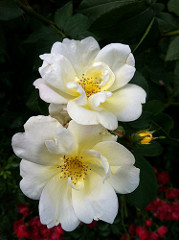

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

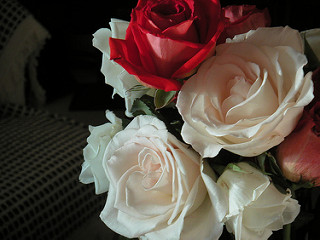

In [9]:
PIL.Image.open(str(roses[1]))

## Load Data

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
train_ds  = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Plot the images

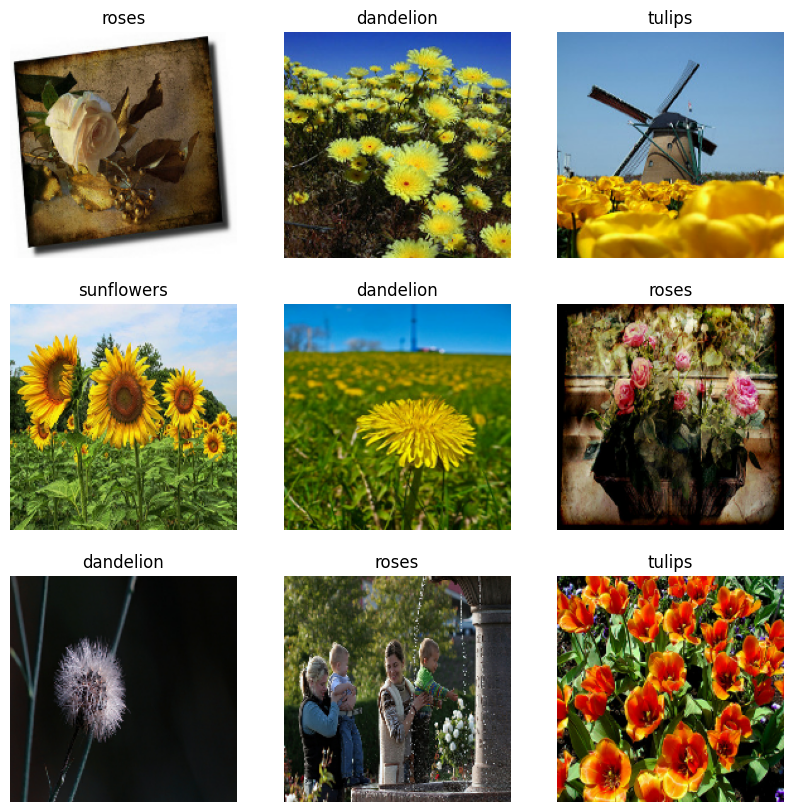

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), " and ", np.max(first_image))

0.0  and  0.96902645


### Configure the dataset for performance

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Define the model

In [19]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
    
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [20]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### Train the model

In [21]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 78s 810ms/step - loss: 1.3043 - accuracy: 0.4268 - val_loss: 1.1294 - val_accuracy: 0.5790
Epoch 2/10
92/92 [==============================] - 63s 686ms/step - loss: 1.0444 - accuracy: 0.5920 - val_loss: 0.9980 - val_accuracy: 0.6049
Epoch 3/10
92/92 [==============================] - 56s 604ms/step - loss: 0.8982 - accuracy: 0.6529 - val_loss: 0.9336 - val_accuracy: 0.6403
Epoch 4/10
92/92 [==============================] - 62s 674ms/step - loss: 0.7654 - accuracy: 0.7125 - val_loss: 0.9174 - val_accuracy: 0.6322
Epoch 5/10
92/92 [==============================] - 61s 665ms/step - loss: 0.6069 - accuracy: 0.7762 - val_loss: 1.0085 - val_accuracy: 0.6158
Epoch 6/10
92/92 [==============================] - 58s 629ms/step - loss: 0.4419 - accuracy: 0.8495 - val_loss: 1.0887 - val_accuracy: 0.6335
Epoch 7/10
92/92 [==============================] - 56s 611ms/step - loss: 0.3453 - accuracy: 0.8815 - val_loss: 1.4293 - val_accuracy: 0.5899

## Using tf.data for finer control

In [22]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [23]:
for f in list_ds.take(5):
    print(f.numpy())

b'datasets\\flower_photos\\roses\\4702438868_278b9cf41c_n.jpg'
b'datasets\\flower_photos\\tulips\\13923036338_1ce32c6d4f.jpg'
b'datasets\\flower_photos\\sunflowers\\15054750690_198b6ab0f2_n.jpg'
b'datasets\\flower_photos\\sunflowers\\15081164641_45a7b92b3a_m.jpg'
b'datasets\\flower_photos\\roses\\5193918046_d44e4fcd75_m.jpg'


In [24]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [25]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [26]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [27]:
class_names

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [28]:
file_path = b'datasets\\flower_photos\\dandelion\\1193386857_3ae53574f2_m.jpg'
parts = tf.strings.split(file_path, os.path.sep)
one_hot = parts[-2] == class_names
tf.argmax(one_hot)

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [29]:
one_hot

<tf.Tensor: shape=(5,), dtype=bool, numpy=array([False,  True, False, False, False])>

### Preparing the dataset

In [30]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [31]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [32]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [33]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [34]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  3


### Configure dataset for performance

In [35]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Plot the images

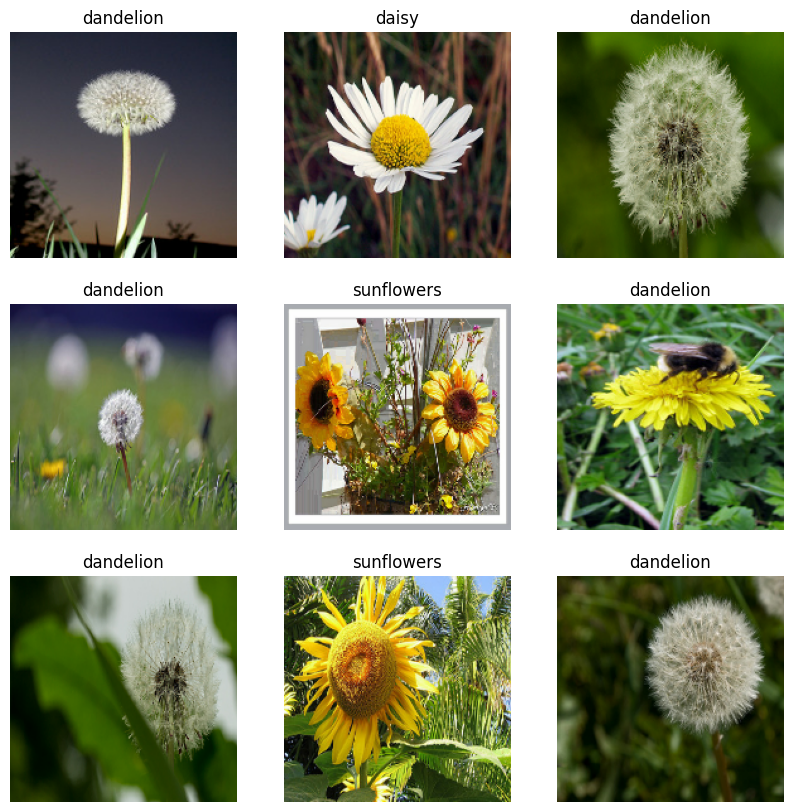

In [36]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

### Train the model

In [37]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 65s 686ms/step - loss: 0.3526 - accuracy: 0.9022 - val_loss: 0.4284 - val_accuracy: 0.8651
Epoch 2/3
92/92 [==============================] - 58s 629ms/step - loss: 0.1247 - accuracy: 0.9659 - val_loss: 0.4211 - val_accuracy: 0.8978
Epoch 3/3
92/92 [==============================] - 59s 647ms/step - loss: 0.0523 - accuracy: 0.9881 - val_loss: 0.4304 - val_accuracy: 0.9183
